# Label side

In [74]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(2831040, 6)

In [75]:
np.save("data/btc_1m.npy", candles)

In [76]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles = candles[candles[:, 5] > 0]
candles.shape

(2828540, 6)

In [77]:
from scipy import stats
from custom_indicators.toolbox.bar.entropy_bar_v2 import EntropyBarContainer

window = 134
window_vol_t = 78
window_vol_ref = 1341
entropy_threshold = 26.96225407898441

entropy_bar_container = EntropyBarContainer(
    window, window_vol_t, window_vol_ref, entropy_threshold
)
entropy_bar_container.update_with_candle(candles)
merged_bar = entropy_bar_container.get_entropy_bar()
np.save("data/merged_bar.npy", merged_bar)
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

10.56356314984221

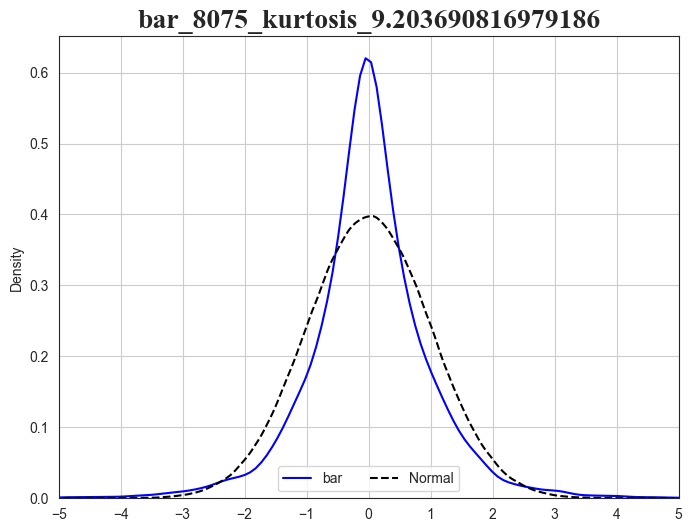

In [144]:
from custom_indicators.utils.plot import plot_kde

L = 5

plot_kde(merged_bar[:, 2], lag=L)

In [145]:
from hmmlearn.hmm import GMMHMM
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from jesse.helpers import timestamp_to_time

mix = 3  ### GMM mix参数

close_arr = merged_bar[:, 2]
high_arr = merged_bar[:, 3][L:]
low_arr = merged_bar[:, 4][L:]

log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
log_return_L = np.log(close_arr[L:] / close_arr[:-L])
HL_diff = np.log(high_arr / low_arr)

X = np.column_stack([HL_diff, log_return_L, log_return])

datelist = np.asarray(
    [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
)
closeidx = merged_bar[:, 2][L:]

assert len(datelist) == len(closeidx)
assert len(datelist) == len(X)

gmm = GMMHMM(
    n_components=3,
    n_mix=mix,
    covariance_type="diag",
    n_iter=1000,
    random_state=42,
    # weights_prior=2,
    means_weight=0.5,
)
gmm.fit(X)
latent_states_sequence = gmm.predict(X)

print(np.unique(latent_states_sequence, return_counts=True))

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i in range(gmm.n_components):
    state = latent_states_sequence == i
    fig.add_trace(
        go.Scatter(
            x=datelist[state],
            y=closeidx[state],
            mode="markers",
            name=f"latent state {i}",
            marker=dict(color=colors[i % len(colors)], size=4),
        )
    )

fig.update_layout(
    title="隐含状态序列",
    xaxis_title="时间",
    yaxis_title="收盘价",
    # width=1400,
    # height=600,
    showlegend=True,
)

fig.show()

(array([0, 1, 2]), array([2055, 2175, 3840]))


state 1 return: 1650.779564%
state 2 return: -0.468860%
state 0 return: -1378.316265%


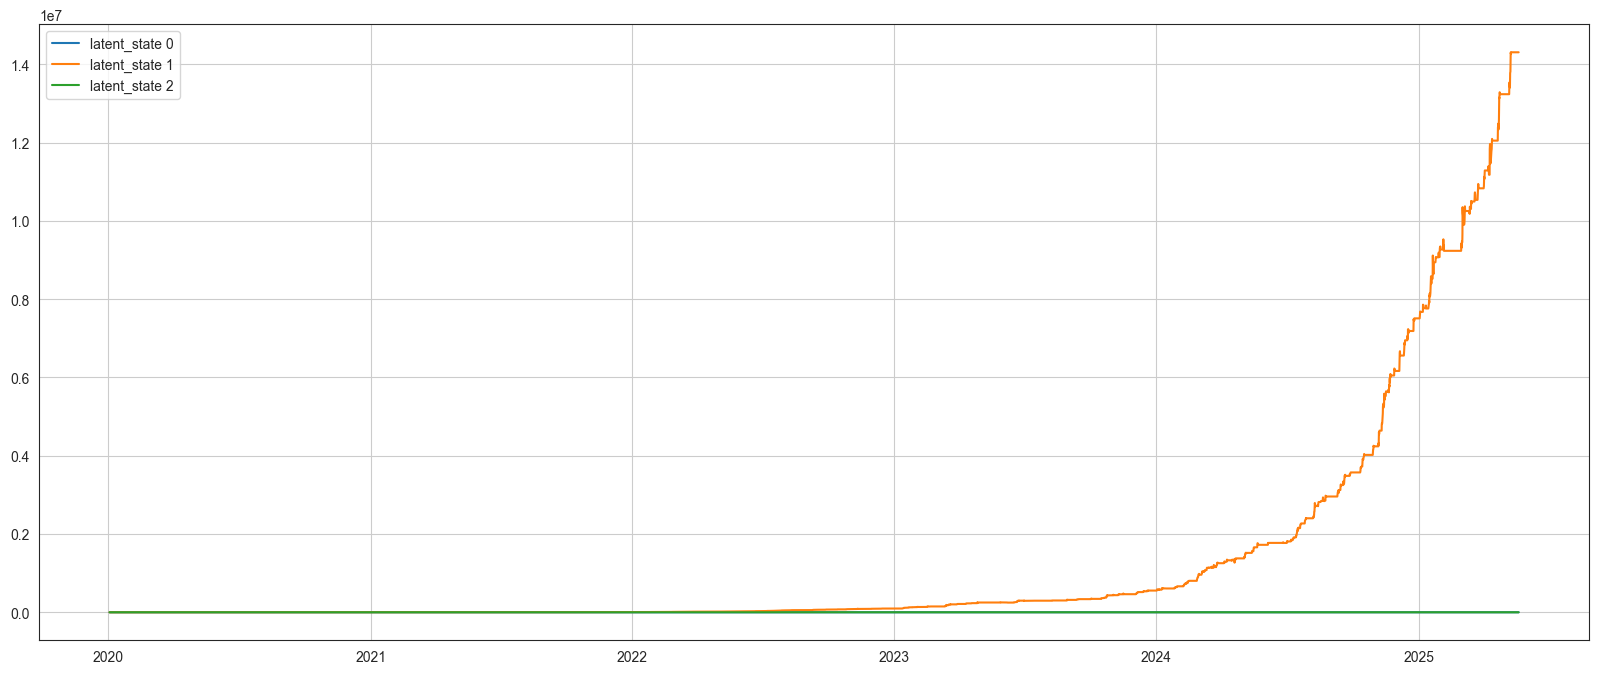

In [146]:
import matplotlib.pyplot as plt

data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": log_return,
        "state": latent_states_sequence,
    }
).set_index("datelist")

for i in data["state"].unique():
    ret = data[data["state"] == i]["logreturn"].sum()
    print(f"state {i} return: {ret:.6%}")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

# Label meta

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from strategies.BinanceMLV2.config import SIDE_ALL

label_side_1h = np.load("data/label_side.npy")
print(label_side_1h.shape)
print(np.unique(label_side_1h[:, 6], return_counts=True))

df_features = pd.read_parquet("data/features_600m.parquet")
print(df_features.shape)

side_model = lgb.Booster(model_file="strategies/BinanceMLV2/model/model_side.txt")
side_model_pred_prob = side_model.predict(df_features[SIDE_ALL])
df_features["side_model_res"] = side_model_pred_prob
side_model_pred = np.where(side_model_pred_prob > 0.5, 1, -1)
print(np.unique(side_model_pred, return_counts=True))

(4614, 7)
(array([-1.,  1.]), array([2100, 2514]))
(4614, 15051)
(array([-1,  1]), array([2078, 2536]))


In [2]:
meta_label = (side_model_pred.astype(int) == label_side_1h[:, 6].astype(int)).astype(
    int
)
np.unique(meta_label, return_counts=True)

(array([0, 1]), array([ 802, 3812]))

In [3]:
label_meta_1h = label_side_1h.copy()
label_meta_1h[:, 6] = meta_label
np.save("data/label_meta.npy", label_meta_1h)